## imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import torch
from torch import nn

import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle


sns.set()

## preprocessing data

In [2]:
def data_preprocessing_input(type_data,name_data,dataset_path):
    
    updated_data_df = pd.DataFrame()
    path_file = f"{dataset_path}{name_data}"

    if type_data == 'raQTL':
        old_data_df = pd.read_csv(path_file, sep='\t')
        updated_data_df['Chromosome'] = old_data_df['chr']
        updated_data_df['Position'] = old_data_df['SNPabspos']
        updated_data_df['Reference'] = old_data_df['ref']
        updated_data_df['Alternative'] = old_data_df['alt']
        if 'hepg2' in  name_data:
            type_cell = 'hepg2'
        else:
            type_cell = 'k562'    
        updated_data_df['Value_Ratio_log2'] = np.log2(old_data_df[f'{type_cell}.alt.mean']/old_data_df[f'{type_cell}.ref.mean'])
        updated_data_df['Value_Diff'] = old_data_df[f'{type_cell}.alt.mean']-old_data_df[f'{type_cell}.ref.mean']
        updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df[f'{type_cell}.wilcox.p.value'])*np.sign(updated_data_df['Value_Ratio_log2'])
        updated_data_df['P_value'] = old_data_df[f'{type_cell}.wilcox.p.value']
    elif type_data == 'mpra':
        old_data_df = pd.read_csv(path_file)
        if 'GSE87711' in name_data:  
            updated_data_df['Chromosome'] = old_data_df['chr'].apply(lambda x: f'chr{x}')
            updated_data_df['Position'] = old_data_df['pos']
            updated_data_df['Reference'] = old_data_df['ref']
            updated_data_df['Alternative'] = old_data_df['alt']
            updated_data_df['Value_Ratio_log2'] = np.log2(old_data_df['CTRL.fc(log2)'])
            updated_data_df['Value_Diff'] = old_data_df['CTRL.padj']-old_data_df['CTRL.mut.padj']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['CTRL.mut.p'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['CTRL.mut.p']
        if 'SORT1' in name_data:
            updated_data_df['Chromosome'] = old_data_df['Chromosome'].apply(lambda x: f'chr{x}')
            updated_data_df['Position'] = old_data_df['Position']
            updated_data_df['Reference'] = old_data_df['Ref']
            updated_data_df['Alternative'] = old_data_df['Alt']
            updated_data_df['Value_Ratio_log2'] = old_data_df['VariantExpressionEffect (log2)']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['P-value'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['P-value']
        if 'GSE68331' in name_data:
            updated_data_df['Chromosome'] = old_data_df['chr3']
            updated_data_df['Position'] = old_data_df['Pos']
            updated_data_df['Reference'] = old_data_df['Allele0']
            updated_data_df['Alternative'] = old_data_df['Allele1']
            updated_data_df['Value_Ratio_log2'] = np.log2(old_data_df['effect'])
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['P'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['P']
        if 'NPC_SNP' in name_data:
            updated_data_df['Chromosome'] = old_data_df['Chromosome']
            updated_data_df['Position'] = old_data_df['Central variant position (hg19)']
            updated_data_df['Reference'] = old_data_df['Archaic sequence sequence'].apply(lambda x: x[99])
            updated_data_df['Alternative'] = old_data_df['Modern sequence sequence'].apply(lambda x: x[99])
            updated_data_df['Value_Ratio_log2'] = old_data_df['Differential activity log2(fold-change) - modern vs archaic - NPC']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['Differential activity P-value - NPC'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['Differential activity P-value - NPC']
        if 'Hela' in name_data:
            updated_data_df['Chromosome'] = old_data_df['chromosome (hg19)']
            updated_data_df['Position'] = old_data_df['coordinate (hg19)']
            updated_data_df['Reference'] = old_data_df['Reference']
            updated_data_df['Alternative'] = old_data_df['Substitution']
            updated_data_df['Value_Ratio_log2'] = old_data_df['HeLa effect size']
            updated_data_df['Value_Pvalue_signed'] = -np.log10(old_data_df['HeLa P-Value'])*np.sign(updated_data_df['Value_Ratio_log2'])
            updated_data_df['P_value'] = old_data_df['HeLa P-Value']            
    return updated_data_df

# Example usage
#data_df = data_preprocessing_input(type_data,name_data,dataset_path)

### Load metadata

In [3]:
data_to_source = pd.read_csv('/data/Dcode/gaetano/repos/AI4Genomic/data/data_mutagenesis.csv')
data_to_source['type_data'] = data_to_source['path'].apply(lambda x: x.split('/')[-2])
data_to_source.head(10)

name                           path hg type  \
0   k562.sign.id.LP190708.txt  /repos/AI4Genomic/data/raQTL/    hg19   
1  hepg2.sign.id.LP190708.txt  /repos/AI4Genomic/data/raQTL/    hg19   
2                   SORT1.csv   /repos/AI4Genomic/data/mpra/    hg38   
3                GSE87711.csv   /repos/AI4Genomic/data/mpra/    hg19   
4            GSE68331_SNP.csv   /repos/AI4Genomic/data/mpra/    hg19   
5                 NPC_SNP.csv   /repos/AI4Genomic/data/mpra/    hg19   
6           Hela_TRAF3IP2.csv   /repos/AI4Genomic/data/mpra/    hg19   
7              Hela_PPARG.csv   /repos/AI4Genomic/data/mpra/    hg19   
8              Hela_SORL1.csv   /repos/AI4Genomic/data/mpra/    hg19   

   #samples cell line           study  \
0     19237      k562  PMID: 31253979   
1     14183     hepg2  PMID: 31253979   
2      1789     hepg2  PMID: 31395865   
3        84      k562  PMID: 27259154   
4       283     hepg2  PMID: 26084464   
5     14042       NPC  PMID: 33885362   
6      1962      Hela  PMID: 25340400   
7      1614      Hela  PMID: 25340400   
8      1665      Hela  PMID: 25340400   

                                            resource    BioS type_data  
0                              https://osf.io/6y9td/  BioS74     raQTL  
1                              https://osf.io/6y9td/  BioS73     raQTL  
2  https://pavlopoulos-lab.org/shinyapps/app/mpra...  BioS73      mpra  
3                                    paper Sup. Mat.  BioS74      mpra  
4                                    paper Sup. Mat.  BioS73      mpra  
5                                    paper Sup. Mat.  BioS45      mpra  
6                                    paper Sup. Mat.   BioS2      mpra  
7                                    paper Sup. Mat.   BioS2      mpra  
8                                    paper Sup. Mat.   BioS2      mpra

## Dataset-wise

#### reshape predictions (get log 2 ratio)

In [4]:
def calculate_logit_ratio(ref_predictions, alt_predictions):
    """Calculate the log2 ratio of alt and ref probabilities using the sigmoid function."""
    ref_margin_logit = ref_predictions[:, 1] - ref_predictions[:, 0]
    alt_margin_logit = alt_predictions[:, 1] - alt_predictions[:, 0]

    ref_probability = 1 / (1 + np.exp(-ref_margin_logit))
    alt_probability = 1 / (1 + np.exp(-alt_margin_logit))

    return np.log2((alt_probability / ref_probability).numpy())

def load_pickle_predictions(file_path):
    """Load a pickle file and return its contents."""
    with open(file_path, 'rb') as file:
        return pickle.load(file, encoding='latin1')

def get_model_predictions(data, models_to_add, data_name):
    """Generate model predictions from data, including additional models."""
    model_predictions = {}

    # Process existing models
    for model, values in data.items():
        model_name = model.split('_')[0]
        model_predictions[model_name] = {
            'Value_Ratio_log2': calculate_logit_ratio(values['ref'], values['alt'])
        }

    # Add external models
    for model_name in models_to_add:
        path_model_pred = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{model_name}_{data_name}.pkl'
        external_data = load_pickle_predictions(path_model_pred)

        if 'tred' in model_name:
            external_data['diff_ratio'] = np.squeeze(external_data['predictions_alt'] / external_data['predictions_ref'])
        
        diff_ratio = external_data.get('diff_ratio', [])
        if not isinstance(diff_ratio, np.ndarray):
            diff_ratio = np.array(diff_ratio)

        model_predictions[model_name] = {
            'Value_Ratio_log2': np.log2(diff_ratio)
        }

    return model_predictions

def get_model_predictions_one_shot(data, models_to_add, data_name):
    """Generate model predictions from data, including additional models."""
    model_predictions = {}

    # Process existing models
    for model, values in data.items():
        model_name = model.split('_')[0]
        model_predictions[model_name] = {
            'Value_Ratio_log2': calculate_logit_ratio(values['ref'], values['alt'])
        }

    # Add external models
    for model_name in models_to_add:
        path_model_pred = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{model_name}_{data_name}.pkl'
        external_data = load_pickle_predictions(path_model_pred)

        if 'tred' in model_name:
            if 'hep' in data_name:
                path_model_pred = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{model_name}_{data_name}_one_shot.pkl'
                print('loading one shot for trednet')
                external_data = load_pickle_predictions(path_model_pred)
            external_data['diff_ratio'] = np.squeeze(external_data['predictions_alt'] / external_data['predictions_ref'])
        
        diff_ratio = external_data.get('diff_ratio', [])
        if not isinstance(diff_ratio, np.ndarray):
            diff_ratio = np.array(diff_ratio)

        model_predictions[model_name] = {
            'Value_Ratio_log2': np.log2(diff_ratio)
        }

    return model_predictions

def get_prediction_ratio_per_experiment(data_to_source):
    """Main function to compute prediction ratios for each experiment."""
    dict_results_per_experiment = {}

    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = f"/data/Dcode/gaetano{row['path']}"
        type_data = row['type_data']

        # Preprocess data and load model predictions
        data_df = data_preprocessing_input(type_data, data_name, dataset_path)
        file_path = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{data_name}.pkl'
        data = load_pickle_predictions(file_path)

        # Get all model predictions
        models_to_add = ['trednet', 'sei', 'enformer', 'borzoi']
        model_predictions = get_model_predictions(data, models_to_add, data_name)
        dict_results_per_experiment[index] = model_predictions

    return dict_results_per_experiment

dict_results_per_experiment = get_prediction_ratio_per_experiment(data_to_source)

/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

### Prediction one-shot


In [5]:
def get_prediction_ratio_per_experiment_one_shot(data_to_source):
    """Main function to compute prediction ratios for each experiment."""
    dict_results_per_experiment = {}

    row = data_to_source.iloc[1]
    data_name = row['name']
    dataset_path = f"/data/Dcode/gaetano{row['path']}"
    type_data = row['type_data']
    
    # Preprocess data and load model predictions
    data_df = data_preprocessing_input(type_data, data_name, dataset_path)
    file_path = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{data_name}_one_shot.pkl'
    data = load_pickle_predictions(file_path)
    # Get all model predictions
    models_to_add = ['trednet', 'sei', 'enformer', 'borzoi']
    model_predictions = get_model_predictions_one_shot(data, models_to_add, data_name)
    dict_results_per_experiment[1] = model_predictions

    return dict_results_per_experiment

dict_results_per_experiment_one_shot = get_prediction_ratio_per_experiment_one_shot(data_to_source)

loading one shot for trednet


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
dict_results_per_experiment_one_shot[1]['trednet']

{'Value_Ratio_log2': array([-1.8698474 ,  1.4630826 ,  0.1810215 , ..., -0.39422143,
        -0.5946587 , -5.499642  ], dtype=float32)}

In [7]:
dict_results_per_experiment[1]['trednet']

{'Value_Ratio_log2': array([ 0.16204874,  1.1860154 ,  0.40001425, ..., -0.28967732,
         0.26948956, -3.138364  ], dtype=float32)}

### preprocessing predictions to get correlation per dataset


In [8]:
def process_model_for_correlation_per_dataset(data_df, model_predictions):
    y = data_df['Value_Ratio_log2'].values
    
    for model_name, value in model_predictions.items():
        x = value['Value_Ratio_log2']

        # Create a mask to filter out both NaN and inf values
        mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

        # Filter the data using the mask
        x_clean = x[mask]
        y_clean = y[mask]
        
        model_predictions[model_name]['data_points'] = (x_clean, y_clean)
        res = stats.linregress(x_clean, y_clean)
        model_predictions[model_name]['r_value'] = res.rvalue
        model_predictions[model_name]['p_value'] = res.pvalue
        model_predictions[model_name]['spearmanr'] = stats.spearmanr(x_clean, y_clean).correlation
        
        # Apply the P-value significance mask on the filtered data
        mask_sign = data_df['P_value'].values[mask] < 0.05

        model_predictions[model_name]['data_points_significant'] = (x_clean[mask_sign], y_clean[mask_sign])
        res = stats.linregress(x_clean[mask_sign], y_clean[mask_sign])
        model_predictions[model_name]['r_value_significant'] = res.rvalue
        model_predictions[model_name]['p_value_significant'] = res.pvalue
        model_predictions[model_name]['spearmanr_significant'] = stats.spearmanr(x_clean[mask_sign], y_clean[mask_sign]).correlation
        model_predictions[model_name]['spearmanr_significant_pvalue'] = stats.spearmanr(x_clean[mask_sign], y_clean[mask_sign]).pvalue
    
    return model_predictions




In [9]:
def get_correlation_per_dataset(data_to_source, dict_results_per_experiment):
    correlation_per_dataset = {}
    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = f"/data/Dcode/gaetano{row['path']}"
        type_data = row['type_data']
    
        # Preprocess data and load model predictions
        data_df = data_preprocessing_input(type_data, data_name, dataset_path)

        correlation_per_dataset[index] = process_model_for_correlation_per_dataset(data_df,dict_results_per_experiment[index])
    return correlation_per_dataset

def get_correlation_per_dataset_one_shot(data_to_source, dict_results_per_experiment_one_shot):
    correlation_per_dataset = {}
    for index, row in data_to_source.iterrows():
        if index != 1:
            continue
        data_name = row['name']
        dataset_path = f"/data/Dcode/gaetano{row['path']}"
        type_data = row['type_data']
    
        # Preprocess data and load model predictions
        data_df = data_preprocessing_input(type_data, data_name, dataset_path)

        correlation_per_dataset[index] = process_model_for_correlation_per_dataset(data_df,dict_results_per_experiment_one_shot[index])
    return correlation_per_dataset

#### Pearson correlation coefficient

In [11]:
# Extract dataset indices and model names
correlation_per_dataset = get_correlation_per_dataset_one_shot(data_to_source, dict_results_per_experiment_one_shot)

dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rvalues = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rvalues[row, col] = correlation_per_dataset[exp][model]['r_value_significant']
        np_pvalues[row, col] = correlation_per_dataset[exp][model]['p_value_significant']

# Convert to DataFrame and apply absolute values
df_ons_shot = pd.DataFrame(np_rvalues, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df_ons_shot = df_ons_shot.style.bar(color='#5fba7d', axis=0)  # Default bar color (will be overridden)



# Display the styled DataFrame
df_ons_shot


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Dataset 2
dnabert2                                       0.027500
nucleotide-transformer-v2-50m-multi-species   -0.002555
nucleotide-transformer-v2-100m-multi-species  -0.002948
nucleotide-transformer-v2-250m-multi-species  -0.014280
nucleotide-transformer-v2-500m-multi-species   0.032133
nucleotide-transformer-500m-1000g              0.024407
nucleotide-transformer-500m-human-ref          0.033527
nucleotide-transformer-2.5b-1000g              0.112695
nucleotide-transformer-2.5b-multi-species      0.021665
Geneformer                                    -0.015246
gena-lm-bert-base-t2t                          0.012053
gena-lm-bert-large-t2t                         0.030339
gena-lm-bert-base-t2t-multi                    0.014462
gena-lm-bigbird-base-t2t                       0.038911
hyenadna-small-32k-seqlen-hf                   0.018442
hyenadna-medium-160k-seqlen-hf                 0.041915
hyenadna-medium-450k-seqlen-hf                 0.009675
hyenadna-large-1m-seqlen-hf                    0.055423
trednet                                        0.238732
sei                                            0.298124
enformer                                       0.136907
borzoi                                         0.125078

In [15]:
# Extract dataset indices and model names
correlation_per_dataset = get_correlation_per_dataset(data_to_source, dict_results_per_experiment)

dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rvalues = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rvalues[row, col] = correlation_per_dataset[exp][model]['r_value_significant']
        np_pvalues[row, col] = correlation_per_dataset[exp][model]['p_value_significant']

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_rvalues, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#5fba7d', axis=0)  # Default bar color (will be overridden)



# Display the styled DataFrame
styled_df


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

In [16]:
df['Dataset 2 one shot'] = df_ons_shot['Dataset 2']
df.to_csv('/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/correlation_per_dataset_2_one_shot.csv')
df

Dataset 1  Dataset 2  Dataset 3  \
dnabert2                                       0.085888   0.097661   0.049236   
nucleotide-transformer-v2-50m-multi-species    0.146801   0.103660   0.128963   
nucleotide-transformer-v2-100m-multi-species   0.151721   0.127979   0.112639   
nucleotide-transformer-v2-250m-multi-species   0.165954   0.111002   0.217302   
nucleotide-transformer-v2-500m-multi-species   0.199470   0.115864  -0.029920   
nucleotide-transformer-500m-1000g              0.122780   0.118675   0.110885   
nucleotide-transformer-500m-human-ref          0.149354   0.119953   0.052059   
nucleotide-transformer-2.5b-1000g              0.147200   0.112760   0.164608   
nucleotide-transformer-2.5b-multi-species      0.153110   0.140341   0.339873   
Geneformer                                     0.005094   0.027681   0.029105   
gena-lm-bert-base-t2t                          0.076582   0.050351  -0.007634   
gena-lm-bert-large-t2t                         0.117423   0.089132   0.191871   
gena-lm-bert-base-t2t-multi                    0.076208   0.063280  -0.058173   
gena-lm-bigbird-base-t2t                       0.136173   0.100408   0.290633   
hyenadna-small-32k-seqlen-hf                   0.084399   0.099580   0.103988   
hyenadna-medium-160k-seqlen-hf                 0.148600   0.144305   0.267030   
hyenadna-medium-450k-seqlen-hf                 0.077183   0.136498   0.072806   
hyenadna-large-1m-seqlen-hf                    0.117697   0.138060   0.125640   
trednet                                        0.315981   0.315603   0.396721   
sei                                            0.298010   0.298124   0.393828   
enformer                                       0.058366   0.136907   0.491650   
borzoi                                         0.032788   0.125078   0.011745   

                                              Dataset 4  Dataset 5  Dataset 6  \
dnabert2                                       0.140452   0.136733  -0.004305   
nucleotide-transformer-v2-50m-multi-species    0.177804   0.321534   0.020959   
nucleotide-transformer-v2-100m-multi-species   0.206698   0.569564   0.021832   
nucleotide-transformer-v2-250m-multi-species   0.141507   0.430987   0.041668   
nucleotide-transformer-v2-500m-multi-species   0.389254   0.028318   0.084387   
nucleotide-transformer-500m-1000g              0.325304   0.067968   0.000339   
nucleotide-transformer-500m-human-ref          0.295910   0.427437   0.001534   
nucleotide-transformer-2.5b-1000g              0.237835   0.181813   0.004219   
nucleotide-transformer-2.5b-multi-species      0.310821   0.490497   0.060088   
Geneformer                                     0.227856   0.120864   0.003576   
gena-lm-bert-base-t2t                          0.150932  -0.138430   0.046884   
gena-lm-bert-large-t2t                         0.203098   0.233700   0.041074   
gena-lm-bert-base-t2t-multi                    0.156275  -0.080907   0.004015   
gena-lm-bigbird-base-t2t                       0.411513  -0.013450   0.039196   
hyenadna-small-32k-seqlen-hf                   0.174325   0.265320   0.018929   
hyenadna-medium-160k-seqlen-hf                 0.289100   0.123102  -0.016000   
hyenadna-medium-450k-seqlen-hf                 0.209330   0.214410  -0.035652   
hyenadna-large-1m-seqlen-hf                    0.243296   0.204231  -0.015656   
trednet                                        0.600733   0.363254   0.166798   
sei                                            0.341251   0.051116   0.189514   
enformer                                       0.409651   0.433740   0.037175   
borzoi                                         0.305573   0.120820   0.050144   

                                              Dataset 7  Dataset 8  Dataset 9  \
dnabert2                                       0.612815   0.480195   0.211020   
nucleotide-transformer-v2-50m-multi-species    0.574805   0.353724   0.217936   
nucleotide-transformer-v2-100m-multi-species   0.525629   0.231811   0.1359

In [17]:
print(df.to_latex(index=True, float_format=lambda x: '%.5f' % x, column_format='lcccc'))

\begin{tabular}{lcccc}
\toprule
{} &  Dataset 1 &  Dataset 2 &  Dataset 3 &  Dataset 4 &  Dataset 5 &  Dataset 6 &  Dataset 7 &  Dataset 8 &  Dataset 9 &  Dataset 2 one shot \\
\midrule
dnabert2                                     &    0.08589 &    0.09766 &    0.04924 &    0.14045 &    0.13673 &   -0.00431 &    0.61282 &    0.48020 &    0.21102 &             0.02750 \\
nucleotide-transformer-v2-50m-multi-species  &    0.14680 &    0.10366 &    0.12896 &    0.17780 &    0.32153 &    0.02096 &    0.57480 &    0.35372 &    0.21794 &            -0.00256 \\
nucleotide-transformer-v2-100m-multi-species &    0.15172 &    0.12798 &    0.11264 &    0.20670 &    0.56956 &    0.02183 &    0.52563 &    0.23181 &    0.13594 &            -0.00295 \\
nucleotide-transformer-v2-250m-multi-species &    0.16595 &    0.11100 &    0.21730 &    0.14151 &    0.43099 &    0.04167 &   -0.38308 &    0.30568 &    0.32943 &            -0.01428 \\
nucleotide-transformer-v2-500m-multi-species &    0.19947 &    0.1

/tmp/ipykernel_2654720/1732357509.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=True, float_format=lambda x: '%.5f' % x, column_format='lcccc'))


DNABERT2, Nucleotide Transformer, Nucleotide Transformer v2, Geneformer, Gena-lm, Hyenadna, TREDNet, SEI, Enformer, Borzoi

#### Spearman

In [18]:
# Extract dataset indices and model names
dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_pear = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_pear[row, col] = correlation_per_dataset[exp][model]['spearmanr_significant']
        

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_pear, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#007bff', axis=0)  # Default bar color (will be overridden)

# Display the styled DataFrame
styled_df


In [19]:
df

Dataset 1  Dataset 2  Dataset 3  \
dnabert2                                       0.136031   0.135830   0.102512   
nucleotide-transformer-v2-50m-multi-species    0.193563   0.169643   0.191334   
nucleotide-transformer-v2-100m-multi-species   0.194391   0.203409   0.222203   
nucleotide-transformer-v2-250m-multi-species   0.230847   0.171191   0.305842   
nucleotide-transformer-v2-500m-multi-species   0.255726   0.187485  -0.020422   
nucleotide-transformer-500m-1000g              0.152636   0.187685   0.147888   
nucleotide-transformer-500m-human-ref          0.158177   0.169706   0.062033   
nucleotide-transformer-2.5b-1000g              0.167780   0.173467   0.284919   
nucleotide-transformer-2.5b-multi-species      0.227509   0.209312   0.341665   
Geneformer                                     0.005852   0.030458   0.043887   
gena-lm-bert-base-t2t                          0.122438   0.114809   0.065979   
gena-lm-bert-large-t2t                         0.169628   0.134975   0.221135   
gena-lm-bert-base-t2t-multi                    0.096045   0.140433   0.012120   
gena-lm-bigbird-base-t2t                       0.169515   0.154783   0.287145   
hyenadna-small-32k-seqlen-hf                   0.110630   0.125602   0.200111   
hyenadna-medium-160k-seqlen-hf                 0.193063   0.201092   0.310149   
hyenadna-medium-450k-seqlen-hf                 0.115706   0.180670   0.147424   
hyenadna-large-1m-seqlen-hf                    0.162267   0.187986   0.182021   
trednet                                        0.314423   0.359624   0.415915   
sei                                            0.287379   0.309127   0.426890   
enformer                                       0.131835   0.217983   0.566397   
borzoi                                         0.088455   0.172024   0.036319   

                                              Dataset 4  Dataset 5  Dataset 6  \
dnabert2                                       0.168164   0.105019   0.017686   
nucleotide-transformer-v2-50m-multi-species    0.348239  -0.018275   0.028590   
nucleotide-transformer-v2-100m-multi-species   0.135056   0.382497   0.015691   
nucleotide-transformer-v2-250m-multi-species   0.196427   0.372201   0.026601   
nucleotide-transformer-v2-500m-multi-species   0.442314   0.226347   0.079436   
nucleotide-transformer-500m-1000g              0.428586  -0.077220   0.013566   
nucleotide-transformer-500m-human-ref          0.527506   0.066152   0.006857   
nucleotide-transformer-2.5b-1000g              0.487534   0.354698   0.016053   
nucleotide-transformer-2.5b-multi-species      0.399920   0.305019   0.040238   
Geneformer                                     0.330474  -0.075676   0.006960   
gena-lm-bert-base-t2t                          0.285253   0.179795   0.059100   
gena-lm-bert-large-t2t                         0.510145   0.359846   0.047194   
gena-lm-bert-base-t2t-multi                    0.409610  -0.138218   0.018905   
gena-lm-bigbird-base-t2t                       0.511760   0.090347   0.036962   
hyenadna-small-32k-seqlen-hf                   0.391441   0.146461   0.011381   
hyenadna-medium-160k-seqlen-hf                 0.487131   0.178121  -0.009069   
hyenadna-medium-450k-seqlen-hf                 0.274352   0.166538  -0.012748   
hyenadna-large-1m-seqlen-hf                    0.452812   0.270013  -0.009757   
trednet                                        0.573131   0.435264   0.134830   
sei                                            0.494802   0.149292   0.147716   
enformer                                       0.374483   0.267181  -0.016166   
borzoi                                         0.269588   0.173018   0.073268   

                                              Dataset 7  Dataset 8  Dataset 9  
dnabert2                                       0.627273   0.512949   0.335512  
nucleotide-transformer-v2-50m-multi-species    0.272727   0.496065   0.251806  
nucleotide-transformer-v2-100m-multi-species   0.545455   0.442192   0.068574 

In [ ]:
models_name

['dnabert2',
 'nucleotide-transformer-v2-50m-multi-species',
 'nucleotide-transformer-v2-100m-multi-species',
 'nucleotide-transformer-v2-250m-multi-species',
 'nucleotide-transformer-v2-500m-multi-species',
 'nucleotide-transformer-500m-1000g',
 'nucleotide-transformer-500m-human-ref',
 'nucleotide-transformer-2.5b-1000g',
 'nucleotide-transformer-2.5b-multi-species',
 'Geneformer',
 'gena-lm-bert-base-t2t',
 'gena-lm-bert-large-t2t',
 'gena-lm-bert-base-t2t-multi',
 'gena-lm-bigbird-base-t2t',
 'hyenadna-small-32k-seqlen-hf',
 'hyenadna-medium-160k-seqlen-hf',
 'hyenadna-medium-450k-seqlen-hf',
 'hyenadna-large-1m-seqlen-hf',
 'trednet',
 'sei',
 'enformer',
 'borzoi']

## Cell Line-wise


In [20]:
# Load TredNet predictions
cell_line_results = {}

for index, row in data_to_source.iterrows():
    cell_line = row['cell line']
    predictions_cell_line = dict_results_per_experiment[index]

    data_name = row['name']
    dataset_path = f"/data/Dcode/gaetano{row['path']}"
    type_data = row['type_data']

    # Preprocess data and load model predictions
    data_df = data_preprocessing_input(type_data, data_name, dataset_path)

    # Initialize cell line entry if needed
    cell_line_results.setdefault(cell_line, {})

    for key, prediction in predictions_cell_line.items():
        # Access or initialize key entry for Value_Ratio_log2 and Experiment_points
        if key not in cell_line_results[cell_line]:
            cell_line_results[cell_line][key] = {
                'Value_Ratio_log2': prediction['Value_Ratio_log2'],
                'Experiment_points': data_df['Value_Ratio_log2'].values
            }
        else:
            cell_line_results[cell_line][key]['Value_Ratio_log2'] = np.concatenate(
                (cell_line_results[cell_line][key]['Value_Ratio_log2'], prediction['Value_Ratio_log2']), axis=0
            )
            cell_line_results[cell_line][key]['Experiment_points'] = np.concatenate(
                (cell_line_results[cell_line][key]['Experiment_points'], data_df['Value_Ratio_log2'].values), axis=0
            )


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

#### preprocessing predictions

In [21]:

def process_model_predictions(cell_line_results):
    model_predictions_cell_line = {}
    for cell_line, models in cell_line_results.items():
        for k,v in models.items():
            y = v['Experiment_points']
            x = v['Value_Ratio_log2']

            # Create a mask to filter out both NaN and inf values
            mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

            # Filter the data using the mask
            x_clean = x[mask]
            y_clean = y[mask]
            
            #model_predictions[k]['data_points'] = (x_clean, y_clean)
            res = stats.linregress(x_clean, y_clean)
            if cell_line not in model_predictions_cell_line.keys():
                model_predictions_cell_line[cell_line] = {}
            if k not in model_predictions_cell_line[cell_line].keys():
                model_predictions_cell_line[cell_line][k] = {}
            model_predictions_cell_line[cell_line][k]['r_value'] = res.rvalue
            model_predictions_cell_line[cell_line][k]['p_value'] = res.pvalue
            model_predictions_cell_line[cell_line][k]['spearmanr'] = stats.spearmanr(x_clean, y_clean).correlation
        
                
    return model_predictions_cell_line


#### plots

In [22]:
cell_line_results
for k, v in cell_line_results.items():
    print(k, cell_line_results[k]['dnabert2']['Experiment_points'].shape)




k562 (19321,)
hepg2 (16255,)
NPC (14042,)
Hela (5241,)


In [26]:
cell_exp_results = process_model_predictions(cell_line_results)

# Extract dataset indices and model names
dataset_index = list(cell_exp_results.keys())  # Sort if order matters
models_name = list(cell_exp_results[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rval = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rval[row, col] = cell_exp_results[exp][model]['spearmanr']
        

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_rval, 
                  columns=[f"{idx}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#007bff', axis=0)  # Default bar color (will be overridden)

# save styled_df
df.to_pickle('/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/df_cellline_correlation_spearman.pkl')

# Display the styled DataFrame
styled_df

In [27]:
df

k562     hepg2       NPC  \
dnabert2                                      0.136255  0.138440  0.009830   
nucleotide-transformer-v2-50m-multi-species   0.193606  0.176066  0.029745   
nucleotide-transformer-v2-100m-multi-species  0.194085  0.210449  0.029202   
nucleotide-transformer-v2-250m-multi-species  0.230211  0.178415  0.031789   
nucleotide-transformer-v2-500m-multi-species  0.255502  0.193536  0.039783   
nucleotide-transformer-500m-1000g             0.152783  0.193222  0.010707   
nucleotide-transformer-500m-human-ref         0.158163  0.174740  0.016139   
nucleotide-transformer-2.5b-1000g             0.167759  0.181192  0.014801   
nucleotide-transformer-2.5b-multi-species     0.226941  0.220580  0.016179   
Geneformer                                    0.005890  0.030644 -0.009830   
gena-lm-bert-base-t2t                         0.122552  0.116882  0.025676   
gena-lm-bert-large-t2t                        0.169897  0.142243  0.041452   
gena-lm-bert-base-t2t-multi                   0.096464  0.140658  0.015713   
gena-lm-bigbird-base-t2t                      0.169682  0.159723  0.023648   
hyenadna-small-32k-seqlen-hf                  0.110639  0.129993  0.000771   
hyenadna-medium-160k-seqlen-hf                0.192700  0.208351  0.007788   
hyenadna-medium-450k-seqlen-hf                0.115686  0.186035  0.007832   
hyenadna-large-1m-seqlen-hf                   0.162212  0.194539  0.012185   
trednet                                       0.313784  0.365124  0.068044   
sei                                           0.287206  0.315009  0.067235   
enformer                                      0.131957  0.230396 -0.005137   
borzoi                                        0.089077  0.173757  0.024613   

                                                  Hela  
dnabert2                                      0.101310  
nucleotide-transformer-v2-50m-multi-species   0.091993  
nucleotide-transformer-v2-100m-multi-species  0.085566  
nucleotide-transformer-v2-250m-multi-species  0.091625  
nucleotide-transformer-v2-500m-multi-species  0.076763  
nucleotide-transformer-500m-1000g             0.064660  
nucleotide-transformer-500m-human-ref         0.058858  
nucleotide-transformer-2.5b-1000g             0.081246  
nucleotide-transformer-2.5b-multi-species     0.091921  
Geneformer                                   -0.009303  
gena-lm-bert-base-t2t                         0.052523  
gena-lm-bert-large-t2t                        0.084151  
gena-lm-bert-base-t2t-multi                   0.047429  
gena-lm-bigbird-base-t2t                      0.088436  
hyenadna-small-32k-seqlen-hf                  0.075399  
hyenadna-medium-160k-seqlen-hf                0.118122  
hyenadna-medium-450k-seqlen-hf                0.093602  
hyenadna-large-1m-seqlen-hf                   0.077734  
trednet                                       0.103394  
sei                                           0.155081  
enformer                                      0.129005  
borzoi                                       -0.019793

In [ ]:
print(df.to_latex(index=True, float_format=lambda x: '%.5f' % x, column_format='lcccc'))

\begin{tabular}{lcccc}
\toprule
{} &    k562 &   hepg2 &      NPC &     Hela \\
\midrule
dnabert2                                     & 0.08592 & 0.09644 & -0.00387 &  0.11972 \\
nucleotide-transformer-v2-50m-multi-species  & 0.14681 & 0.10278 &  0.01974 &  0.07430 \\
nucleotide-transformer-v2-100m-multi-species & 0.15166 & 0.12655 &  0.01638 &  0.04183 \\
nucleotide-transformer-v2-250m-multi-species & 0.16575 & 0.11014 &  0.02279 &  0.02956 \\
nucleotide-transformer-v2-500m-multi-species & 0.19861 & 0.11433 &  0.02789 &  0.03601 \\
nucleotide-transformer-500m-1000g            & 0.12297 & 0.11631 &  0.00141 &  0.02245 \\
nucleotide-transformer-500m-human-ref        & 0.14938 & 0.11868 &  0.01302 &  0.06652 \\
nucleotide-transformer-2.5b-1000g            & 0.14717 & 0.11156 &  0.00500 &  0.08712 \\
nucleotide-transformer-2.5b-multi-species    & 0.15293 & 0.13880 &  0.02652 &  0.06617 \\
Geneformer                                   & 0.00522 & 0.02728 & -0.00163 & -0.00736 \\
gena-lm-ber

/tmp/ipykernel_3147860/1732357509.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=True, float_format=lambda x: '%.5f' % x, column_format='lcccc'))


## Unify datasets


### data collection

In [ ]:
# Load TredNet predictions
data_experiment = {'Value_Ratio_log2':[], 'p_values':[]}
model_predictions_all = {}

for index, row in data_to_source.iterrows():
    cell_line = row['cell line']

    data_name = row['name']
    dataset_path = f"/data/Dcode/gaetano{row['path']}"
    type_data = row['type_data']

    # Preprocess data and load model predictions
    data_df = data_preprocessing_input(type_data, data_name, dataset_path)

    data_experiment['Value_Ratio_log2'].extend(data_df['Value_Ratio_log2'].values)
    data_experiment['p_values'].extend(data_df['P_value'].values)

    for model_name, values in dict_results_per_experiment[index].items():
        if model_name not in model_predictions_all.keys():
            model_predictions_all[model_name]={}
            model_predictions_all[model_name]['Value_Ratio_log2'] = []
        model_predictions_all[model_name]['Value_Ratio_log2'].extend(values['Value_Ratio_log2'])



/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

In [ ]:
def clean_predictions(model_predictions, data_exp):
    
    y = np.array(data_exp['Value_Ratio_log2'])
    
    for model, val in model_predictions.items():
        x = np.array(val['Value_Ratio_log2'])

        finite_mask = np.isfinite(x) & np.isfinite(y)
        x_clean = x[finite_mask]
        y_clean = y[finite_mask]

        model_predictions[model]['p_values'] = np.array(data_exp['p_values'])[finite_mask]
        model_predictions[model]['data_points_clean'] = (x_clean, y_clean)

    return model_predictions
    
    
    

In [ ]:
len(model_predictions_all['dnabert2']['Value_Ratio_log2'])

54859

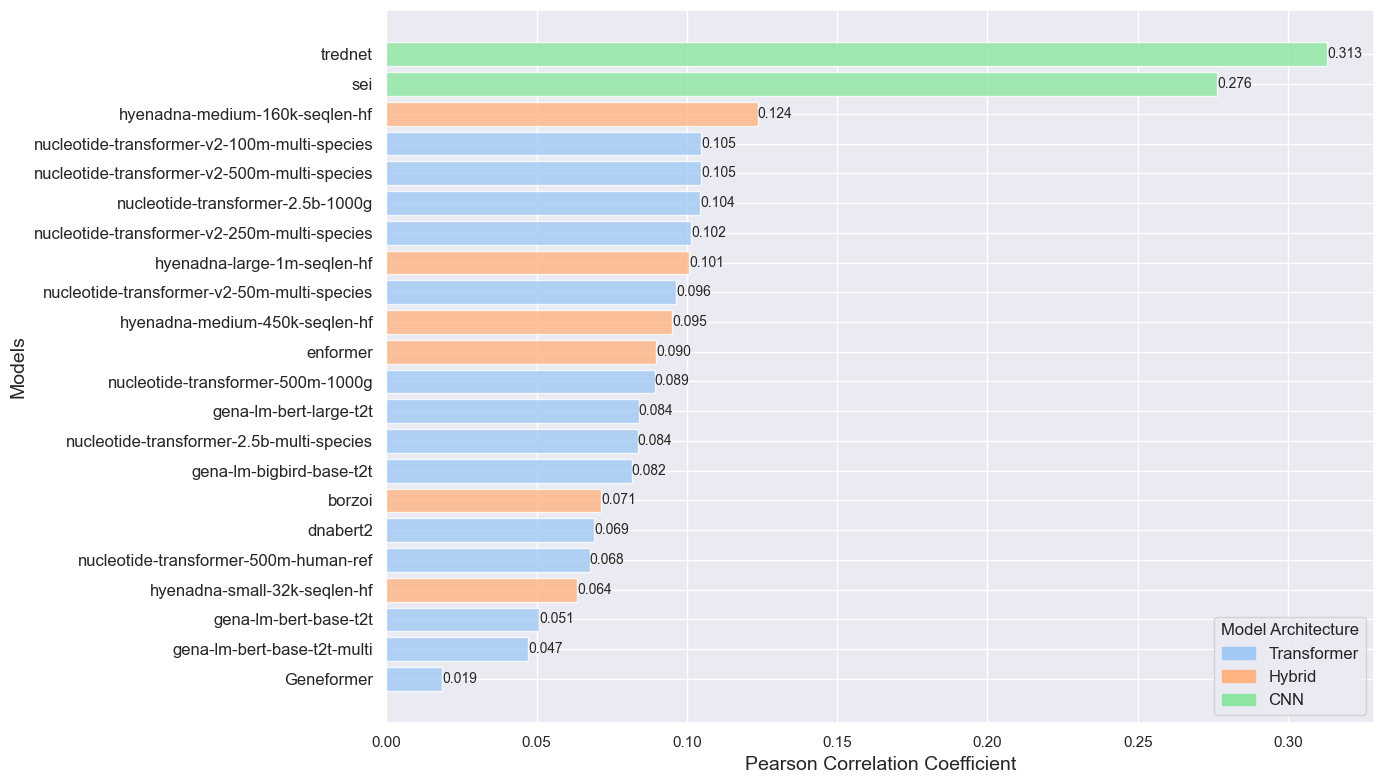

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set()

# Assuming dict_all_predictions is already populated with predictions
dict_all_predictions = clean_predictions(model_predictions_all, data_experiment)
models = list(dict_all_predictions.keys())

# Architecture mapping
architecture_mapping = {
    'dnabert2': 'Transformer',
    'nucleotide-transformer-v2-50m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-100m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-250m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-500m-multi-species': 'Transformer',
    'nucleotide-transformer-500m-1000g': 'Transformer',
    'nucleotide-transformer-500m-human-ref': 'Transformer',
    'nucleotide-transformer-2.5b-1000g': 'Transformer',
    'nucleotide-transformer-2.5b-multi-species': 'Transformer',
    'Geneformer': 'Transformer',
    'gena-lm-bert-base-t2t': 'Transformer',
    'gena-lm-bert-large-t2t': 'Transformer',
    'gena-lm-bert-base-t2t-multi': 'Transformer',
    'gena-lm-bigbird-base-t2t': 'Transformer',
    'hyenadna-small-32k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-160k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-450k-seqlen-hf': 'Hybrid',
    'hyenadna-large-1m-seqlen-hf': 'Hybrid',
    'trednet': 'CNN',
    'sei': 'CNN',
    'enformer': 'Hybrid',
    'borzoi': 'Hybrid',
}

# Use Seaborn's pastel color palette
palette = sns.color_palette("pastel", n_colors=len(set(architecture_mapping.values())))

# Color mapping based on architectures
architecture_colors = {
    'Transformer': palette[0],  # First pastel color
    'Hybrid': palette[1],       # Second pastel color
    'CNN': palette[2],          # Third pastel color
}

# Calculating r-values and collecting architectures
r_values = []
architectures = []
for model in models:
    r_value = stats.linregress(dict_all_predictions[model]['data_points_clean']).rvalue
    r_values.append(r_value)
    architectures.append(architecture_mapping[model])  # Get architecture

# Sorting models, r-values, and architectures based on r-values
models_sorted, r_values_sorted, architectures_sorted = zip(
    *sorted(zip(models, r_values, architectures), key=lambda x: x[1])
)

# Create a figure and axis with increased width
fig, ax = plt.subplots(figsize=(14, 8))  # Adjusted width to 14

# Color mapping based on architectures
colors = [architecture_colors[arch] for arch in architectures_sorted]

# Horizontal bar plot for r-values (sorted)
bars = ax.barh(models_sorted, r_values_sorted, label='r-value', color=colors, alpha=0.8)

# Adding titles and labels
#ax.set_title('Pearson Correlation Coefficient for Model Predictions', fontsize=18)
ax.set_xlabel('Pearson Correlation Coefficient', fontsize=14)
ax.set_ylabel('Models', fontsize=14)

# Creating a custom legend for architectures
handles = [plt.Rectangle((0, 0), 1, 1, color=architecture_colors[arch]) for arch in architecture_colors]
labels = list(architecture_colors.keys())
ax.legend(handles, labels, title='Model Architecture', loc='lower right', fontsize=12)

# Adjusting y-tick font size
ax.tick_params(axis='y', labelsize=12)  # Adjust the label size as needed

# Adding r-value annotations
for i in range(len(r_values_sorted)):
    ax.text(r_values_sorted[i], i, f'{r_values_sorted[i]:.3f}', va='center', fontsize=10)

# Show the plot with adjusted layout
plt.tight_layout()
plt.show()

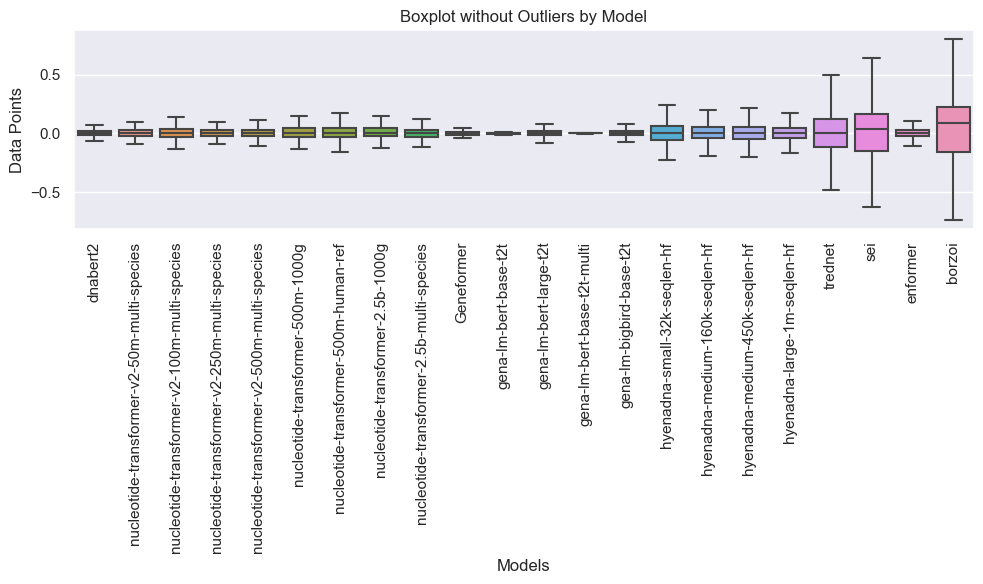

In [20]:

data = []
models = list(dict_all_predictions.keys())

# Flattening the data and associating them with their corresponding models
for model in models:
    data_points = dict_all_predictions[model]['data_points_clean'][0]  # First array of data_points
    for value in data_points:
        data.append({'Model': model, 'Data Point': value})

# Convert to pandas DataFrame for seaborn
df = pd.DataFrame(data)

# Create a boxplot for the data points without showing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Data Point', data=df, showfliers=False)

# Adding titles and labels
plt.title('Boxplot without Outliers by Model')
plt.xlabel('Models')
plt.ylabel('Data Points')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
def process_models(dict_all_predictions):
    df_significant_data = []
    for model_name, value_dict in dict_all_predictions.items():
        # Ensure data points exist
        if model_name not in ['trednet', 'hyenadna-medium-160k-seqlen-hf', 'nucleotide-transformer-v2-250m-multi-species']:
            continue
        data_points = value_dict['data_points_clean']
        p_values = value_dict['p_values']
        
        if len(data_points) != 2 or len(p_values) == 0:
            print(f"Skipping model {model_name}: Invalid data structure.")
            continue

        # Create a dataframe for the full dataset
        df_full = pd.DataFrame({
            'Model log2 ratio': data_points[0],
            'Experiment log2 ratio': data_points[1]
        })
        
        # Prepare to collect significant dataframes and their r-values
        
        # Create a dataframe for the significant dataset

        # Filtering significant data points based on different p-value thresholds
        #thresholds = [0.05, 0.01, 0.00005]
        
        threshold = 0.00005
       
        mask = p_values < threshold
        filtered_data_points = (data_points[0][mask], data_points[1][mask])
            

            
        # Calculate correlation values
        r_val = stats.linregress(data_points).rvalue
        r_val_sig = stats.linregress(filtered_data_points).rvalue
            
            
        
        df_significant = pd.DataFrame({
            'Model log2 ratio': filtered_data_points[0],
            'Experiment log2 ratio': filtered_data_points[1],
            'Model Name': model_name
        })
        print(model_name)
       # Store the significant dataframe and r-value with the corresponding threshold
        df_significant_data.append(df_significant)
    return df_significant_data

df_significant_data_test = process_models(dict_all_predictions)

nucleotide-transformer-v2-250m-multi-species
hyenadna-medium-160k-seqlen-hf
trednet


In [22]:
import pandas as pd

# Concatenate the three dataframes
df_concat = pd.concat([df_significant_data_test[0], df_significant_data_test[1], df_significant_data_test[2]])

# Reset the index (optional)
df_concat = df_concat.reset_index(drop=True)
df_concat

Model log2 ratio  Experiment log2 ratio  \
0              0.351197               4.477955   
1             -0.014305              -4.258335   
2             -0.041880              -3.153026   
3              0.679454               3.967905   
4             -0.017577              -4.074958   
...                 ...                    ...   
36850         -0.635591               0.286400   
36851         -0.522712              -0.590500   
36852         -0.330570              -0.476200   
36853          0.013673               1.044300   
36854          0.049483               0.580700   

                                         Model Name  
0      nucleotide-transformer-v2-250m-multi-species  
1      nucleotide-transformer-v2-250m-multi-species  
2      nucleotide-transformer-v2-250m-multi-species  
3      nucleotide-transformer-v2-250m-multi-species  
4      nucleotide-transformer-v2-250m-multi-species  
...                                             ...  
36850                                       trednet  
36851                                       trednet  
36852                                       trednet  
36853                                       trednet  
36854                                       trednet  

[36855 rows x 3 columns]

In [23]:
 
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_significant_data_test[0][0] is the dataframe you want to plot
df = df_concat


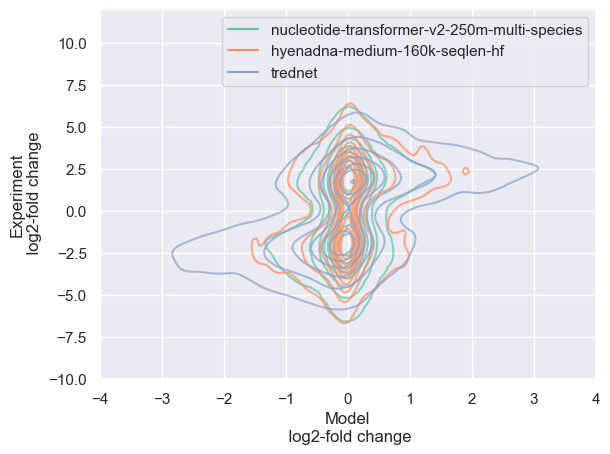

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure visualization settings
sns.set()

# Generate kernel density estimate (KDE) plot
g = sns.kdeplot(
    data=df,
    x='Model log2 ratio',
    y='Experiment log2 ratio',
    hue="Model Name",
    palette="Set2",
    alpha=0.7
)

# Set plot limits
plt.xlim(-4, 4)
plt.ylim(-10, 12)

# Add plot annotations

g.set_xlabel('Model\n log2-fold change')
g.set_ylabel('Experiment\n log2-fold change')

# Remove the title from the legend
g.legend_.set_title("")




# Display plot
plt.show()


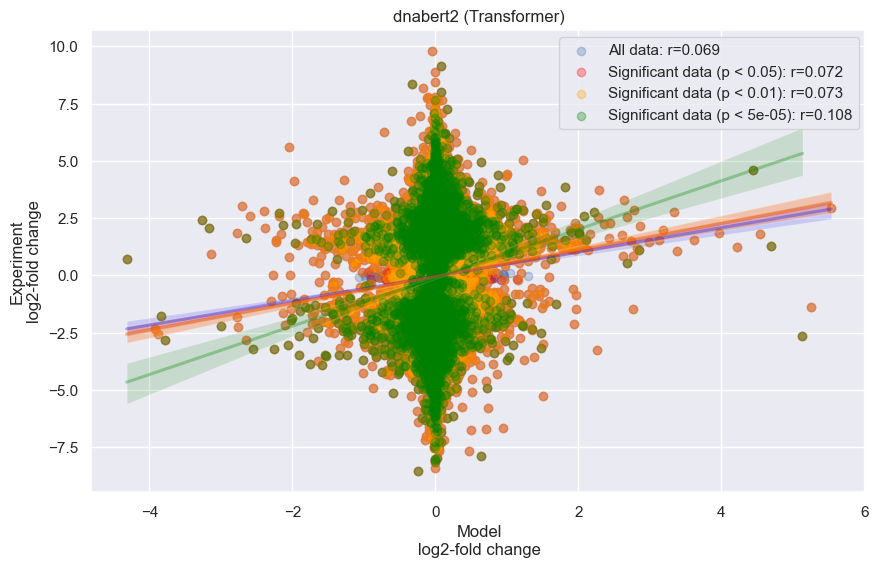

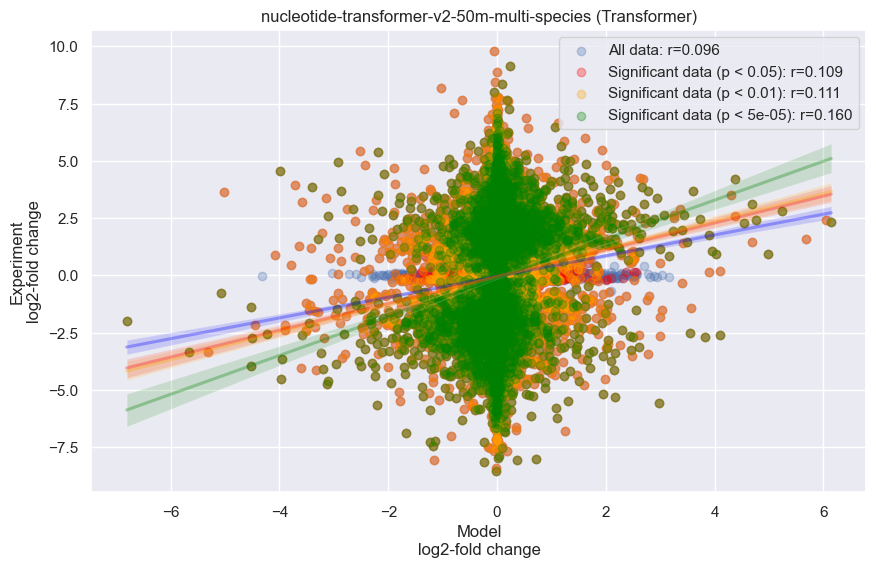

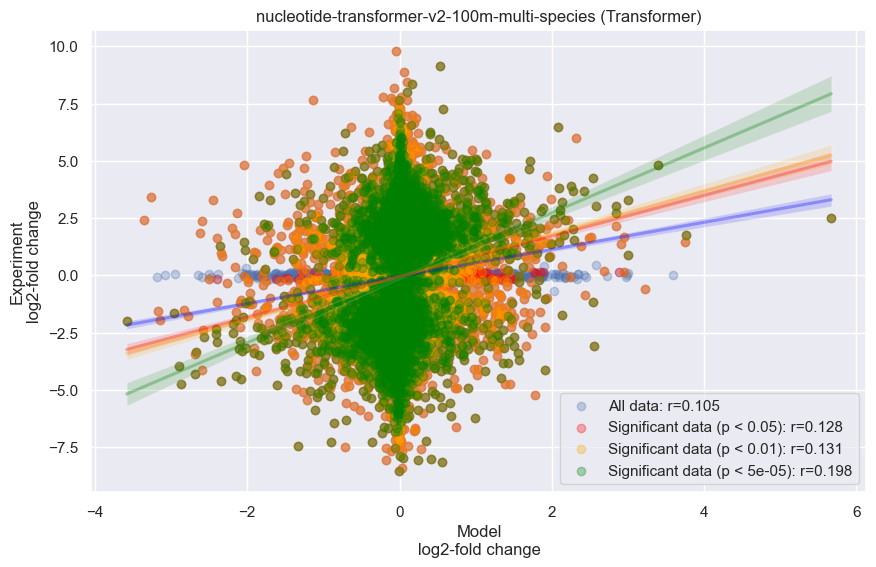

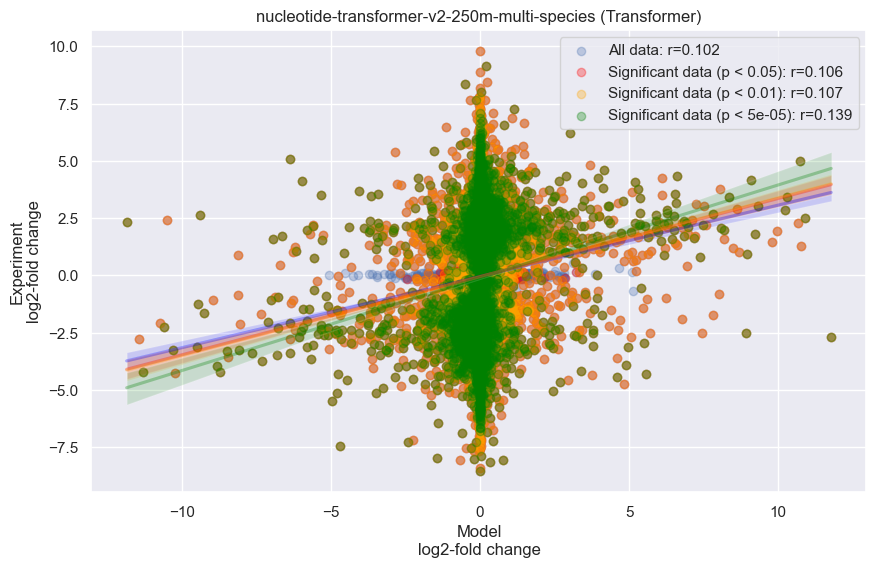

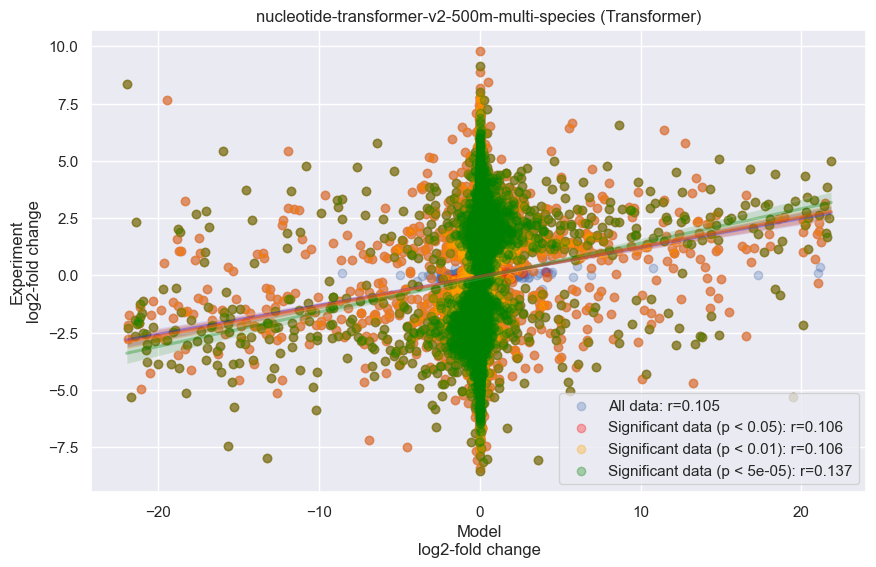

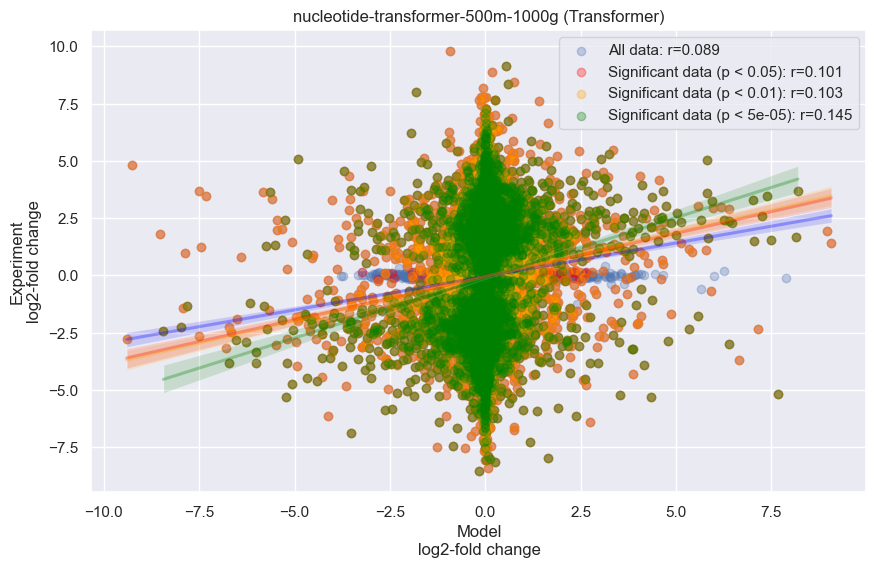

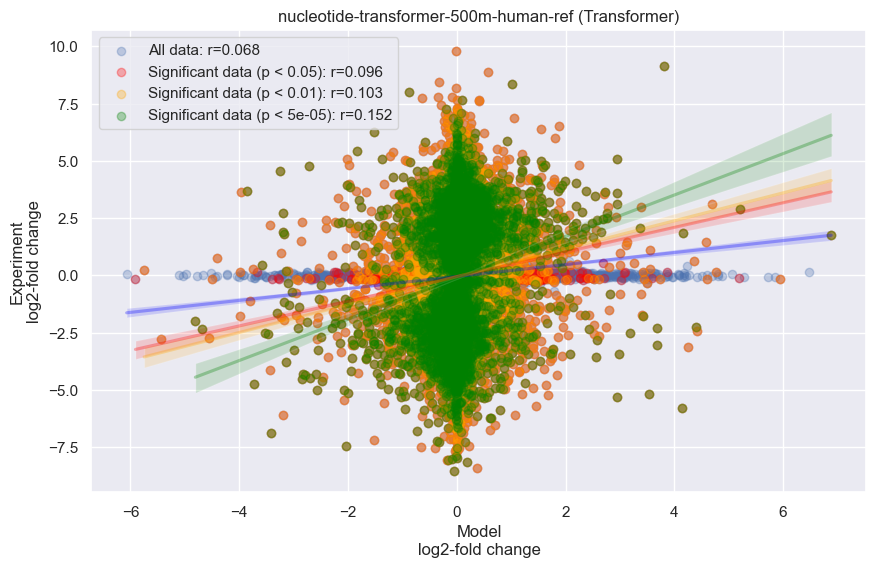

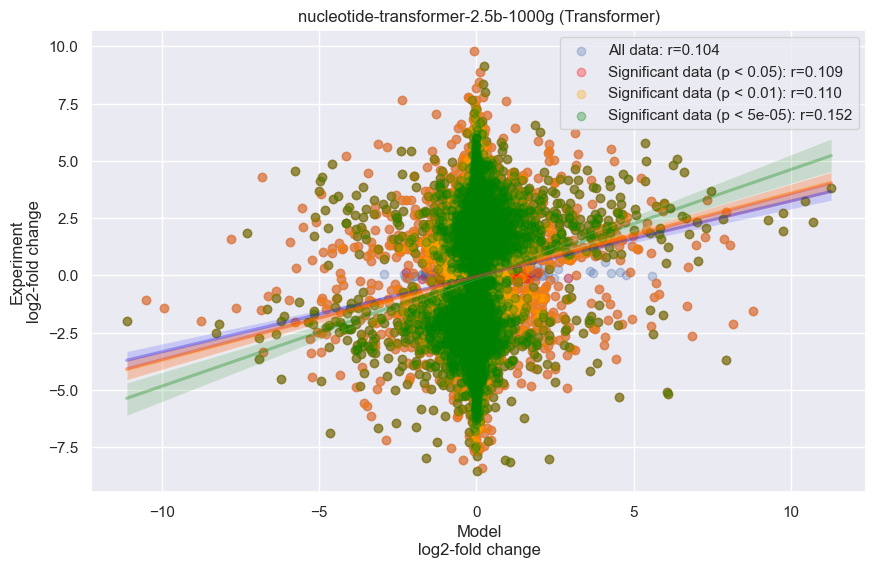

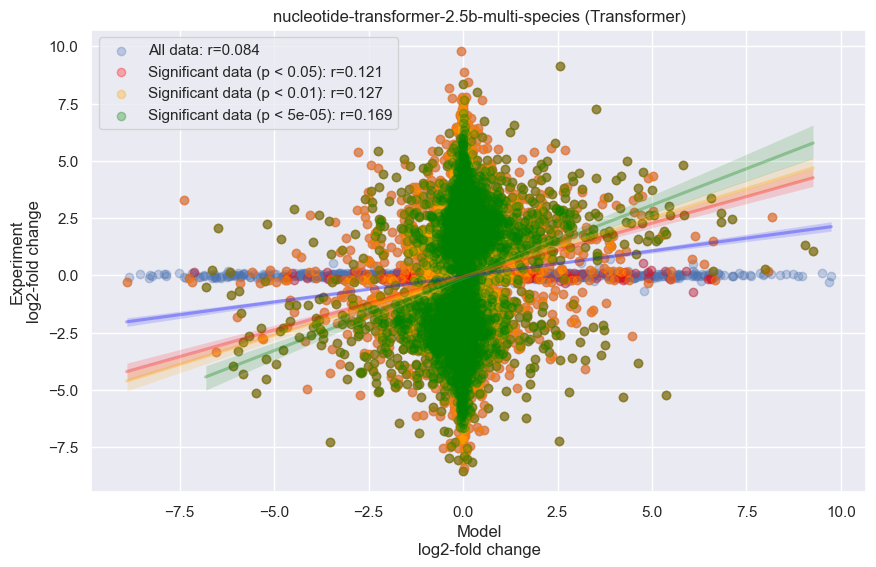

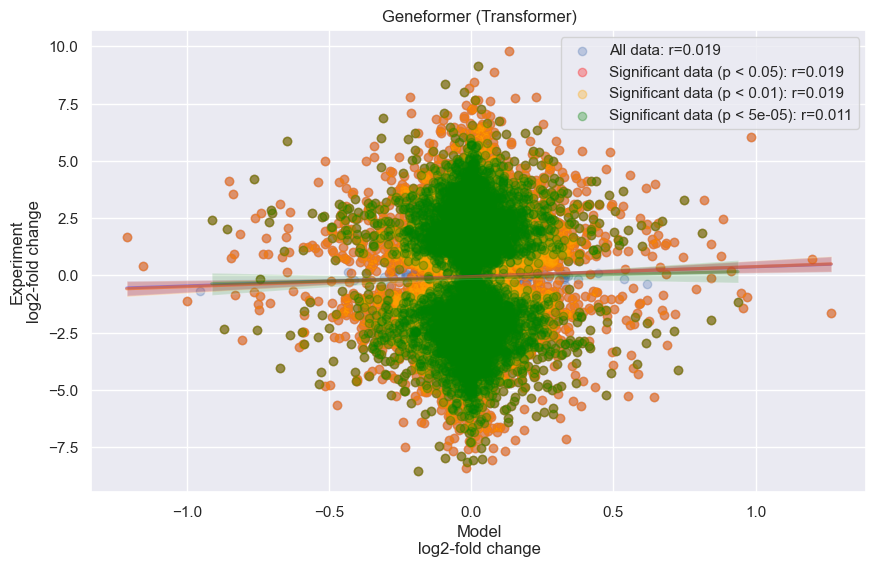

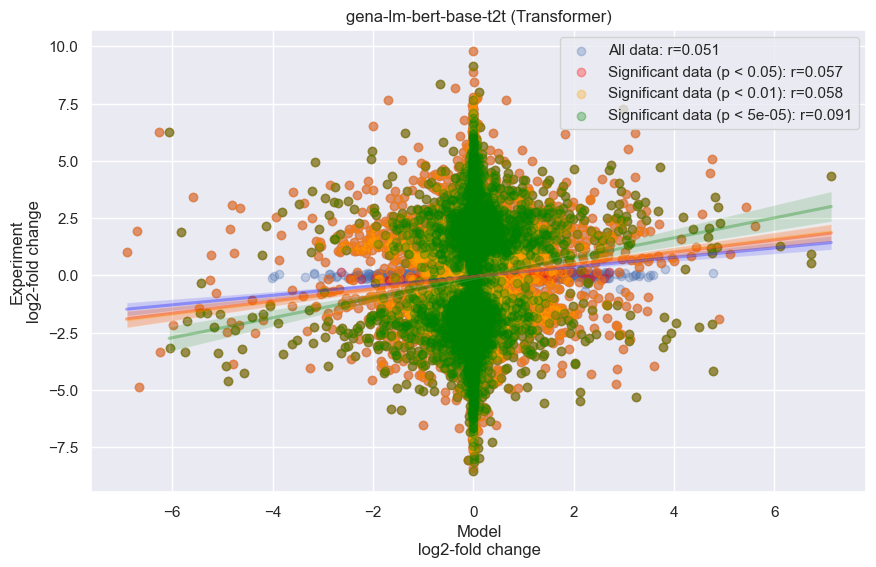

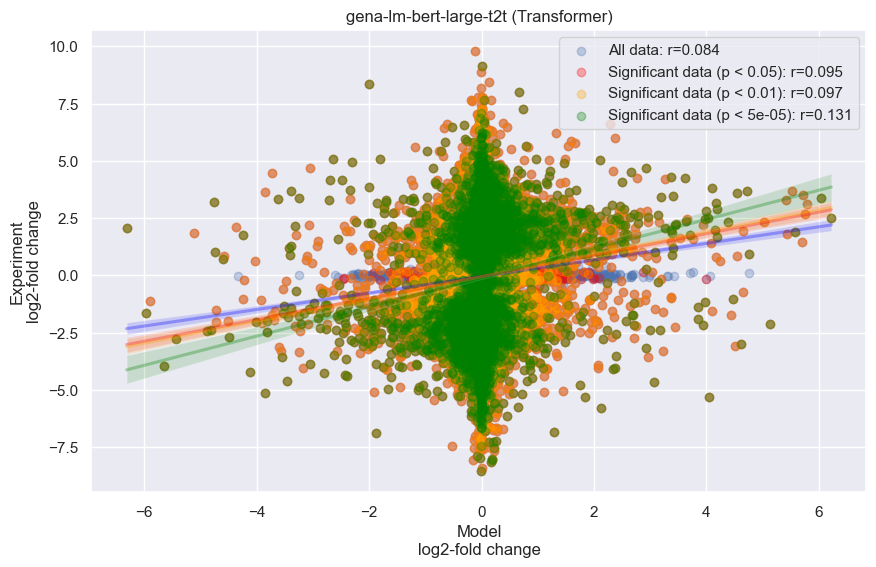

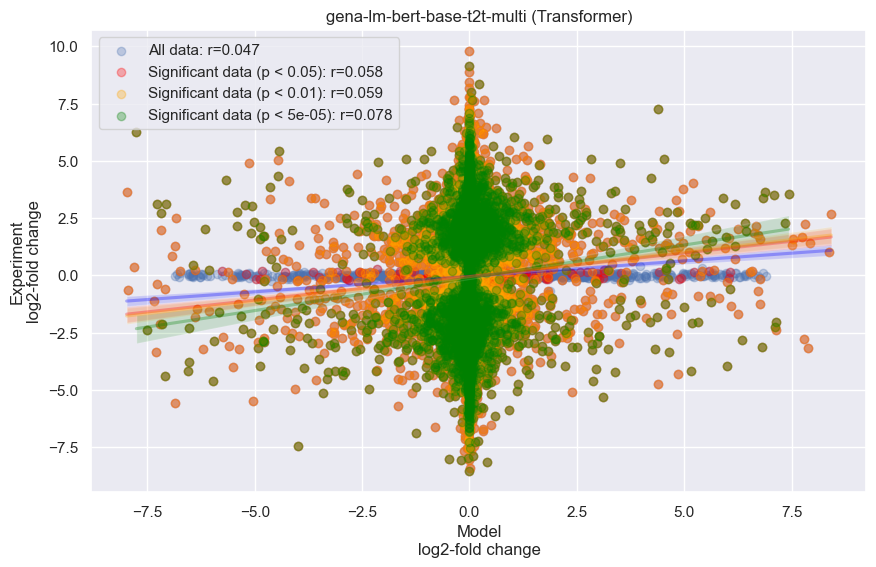

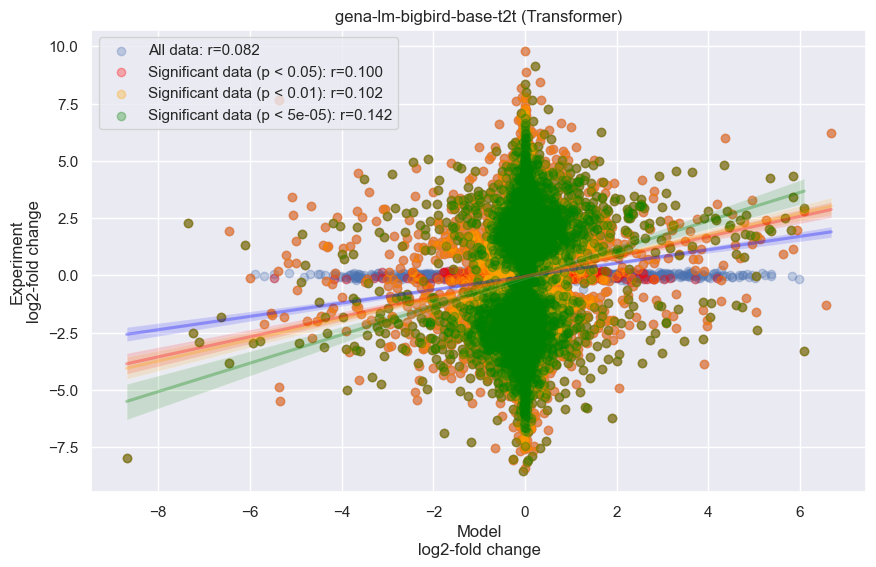

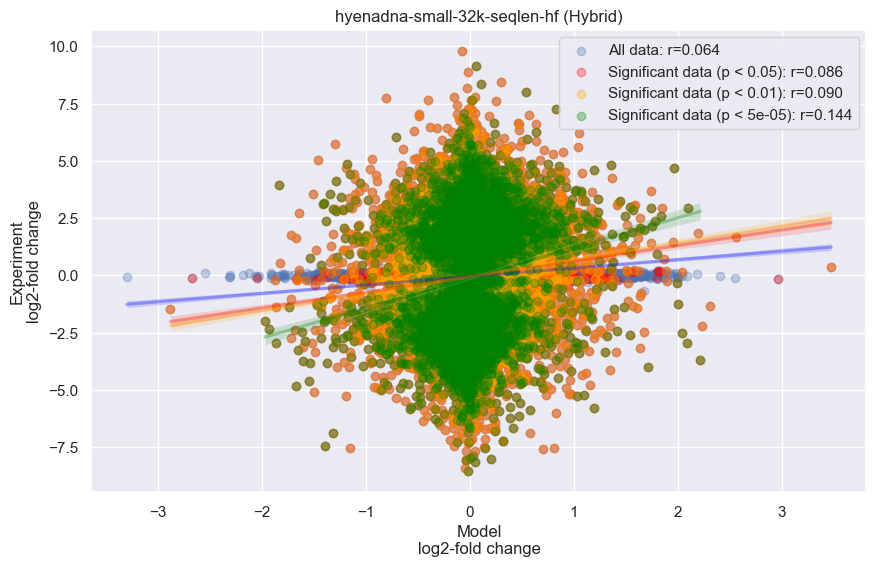

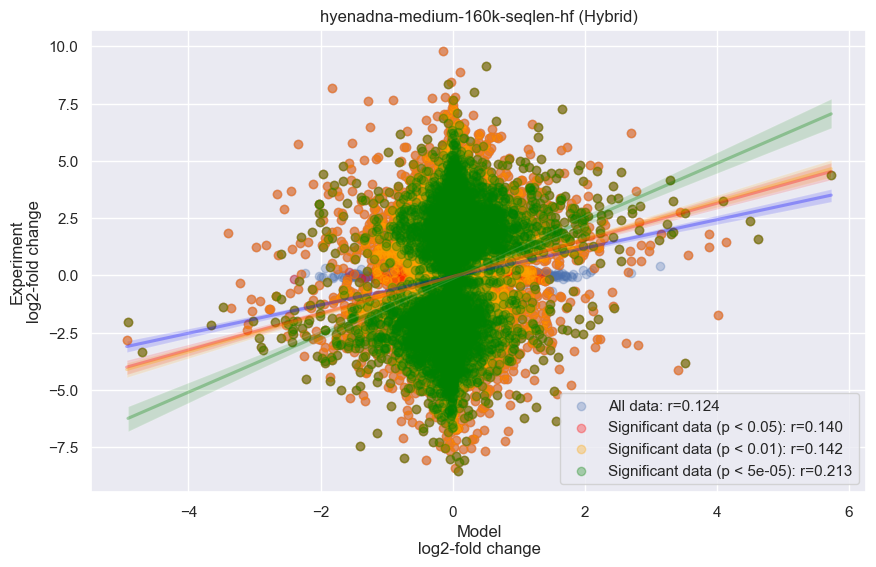

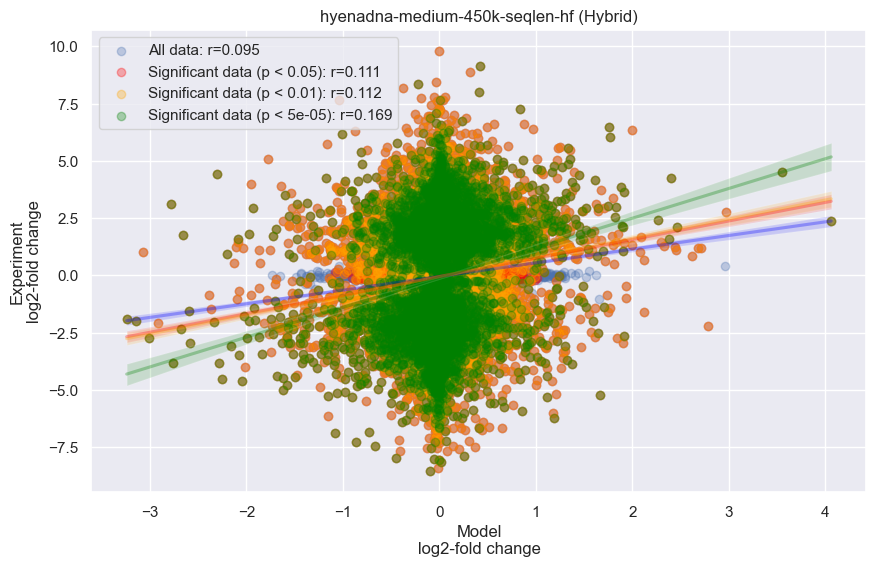

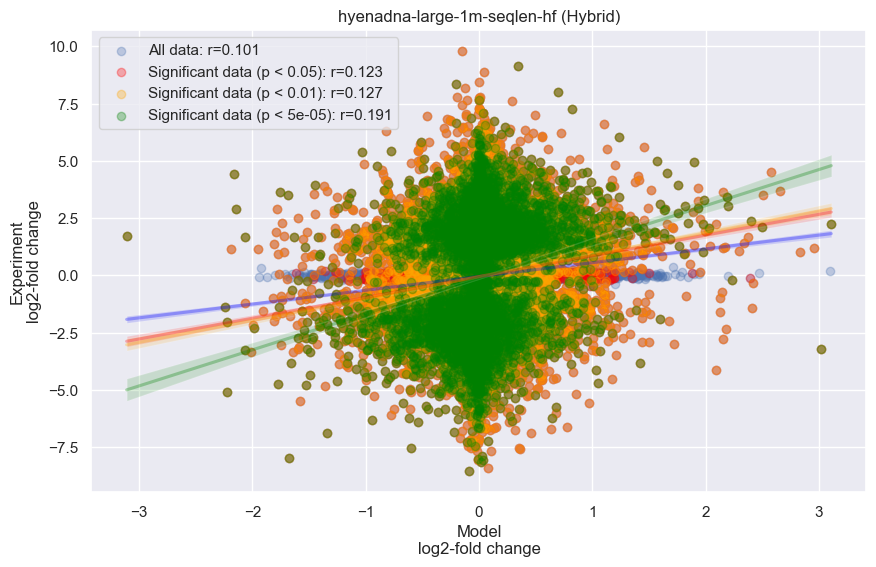

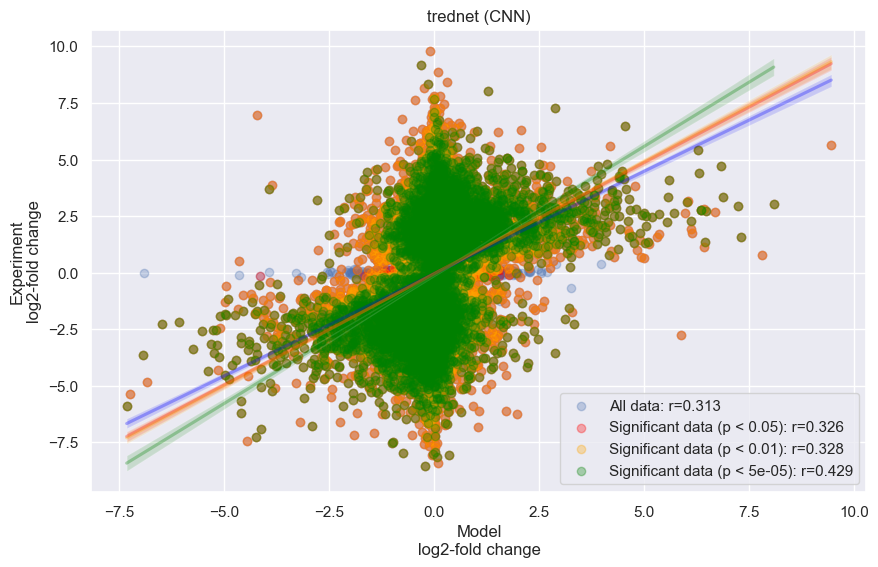

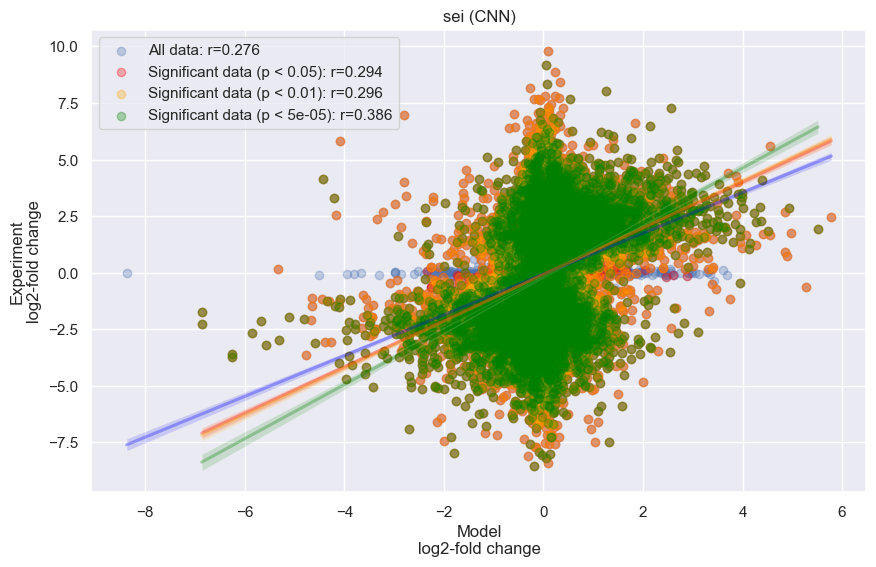

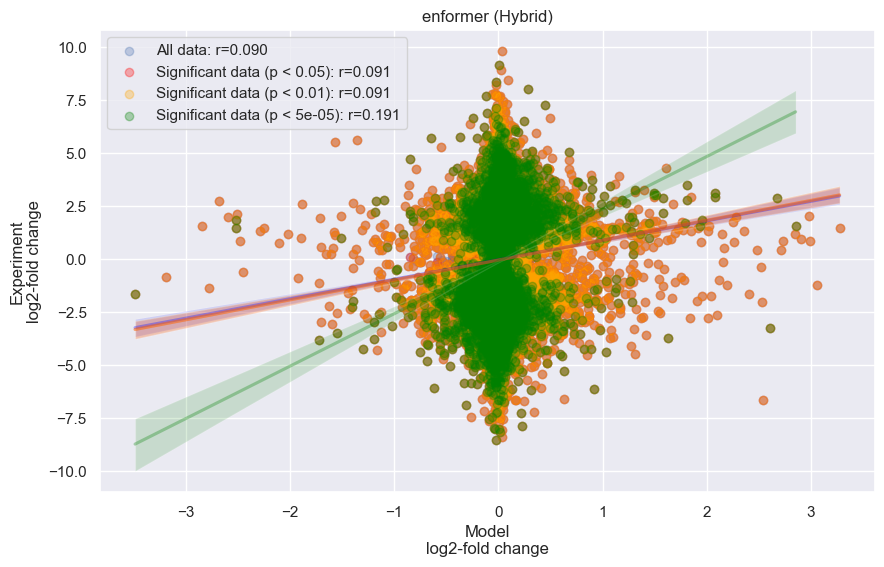

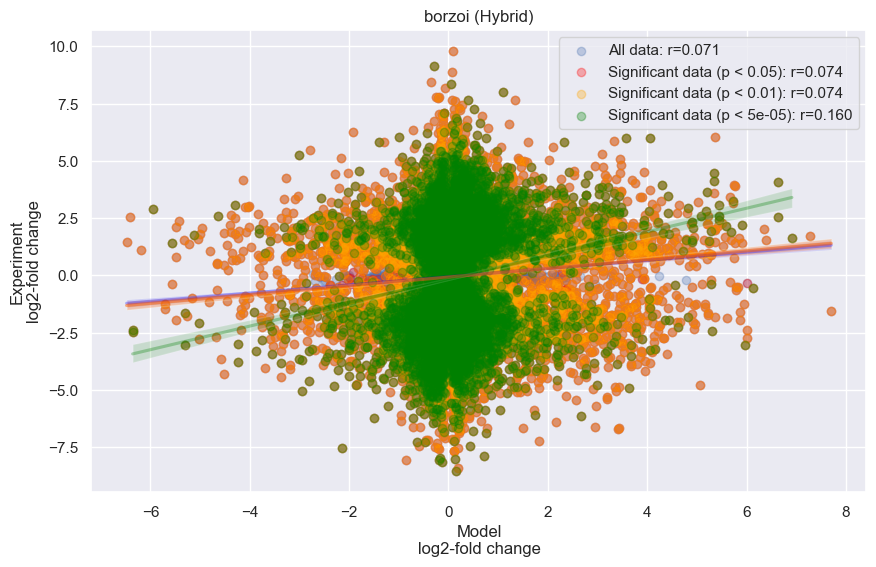

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict

def plot_regression(df_full, df_significant_data, model, r_val):
    plt.figure(figsize=(10, 6))
    
    # Plot for the full dataset
    sns.regplot(
        x='Model log2 ratio',
        y='Experiment log2 ratio',
        data=df_full,
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'blue', 'alpha': 0.3},
        label=f"All data: r={r_val:.3f}"
    )
    
    # Color mapping for different p-value thresholds
    color_map = {
        0.05: 'red',       # p < 0.05
        0.01: 'orange',    # p < 0.01
        0.00005: 'green'   # p < 0.00005
    }
    
    # Plot for each significant dataset with its p-value threshold
    for (df_sig, threshold, r_val_sig) in df_significant_data:
        line_color = color_map.get(threshold, 'black')  # Default color if threshold is not found
        sns.regplot(
            x='Model log2 ratio (significant)',
            y='Experiment log2 ratio (significant)',
            data=df_sig,
            scatter_kws={'alpha': 0.3, 'color': line_color},
            line_kws={'color': line_color, 'alpha': 0.3},
            label=f"Significant data (p < {threshold}): r={r_val_sig:.3f}"
        )
    
    plt.ylabel('Experiment\nlog2-fold change')
    plt.xlabel('Model\nlog2-fold change')
    plt.title(f'{model} ({architecture_mapping[model]})')
    plt.legend()
    plt.show()

def process_models_regplot(dict_all_predictions: Dict):
    for model_name, value_dict in dict_all_predictions.items():
        # Ensure data points exist
        data_points = value_dict['data_points_clean']
        p_values = value_dict['p_values']
        
        if len(data_points) != 2 or len(p_values) == 0:
            print(f"Skipping model {model_name}: Invalid data structure.")
            continue

        # Create a dataframe for the full dataset
        df_full = pd.DataFrame({
            'Model log2 ratio': data_points[0],
            'Experiment log2 ratio': data_points[1]
        })
        
        # Prepare to collect significant dataframes and their r-values
        df_significant_data = []
        
        # Filtering significant data points based on different p-value thresholds
        thresholds = [0.05, 0.01, 0.00005]
        for threshold in thresholds:
            mask = p_values < threshold
            filtered_data_points = (data_points[0][mask], data_points[1][mask])
            
            # Create a dataframe for the significant dataset
            df_significant = pd.DataFrame({
                'Model log2 ratio (significant)': filtered_data_points[0],
                'Experiment log2 ratio (significant)': filtered_data_points[1]
            })
            
            # Calculate correlation values
            r_val = stats.linregress(data_points).rvalue
            r_val_sig = stats.linregress(filtered_data_points).rvalue
            
            # Store the significant dataframe and r-value with the corresponding threshold
            df_significant_data.append((df_significant, threshold, r_val_sig))
        
        # Plot the regression with all significant data on the same plot
        plot_regression(df_full, df_significant_data, model_name, r_val)

# Call the function to process models
process_models_regplot(dict_all_predictions)
